In [263]:
import numpy as np 
import scipy.io as sio  
import os 
import matplotlib.pyplot as plt 
import seaborn as sns   
import pandas as pd
from scipy.ndimage import gaussian_filter 
from scipy.stats import zscore 
import random 
from sklearn import metrics  
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.svm import SVC 
from sklearn.preprocessing import PolynomialFeatures 
from progress.bar import IncrementalBar

# import smoothing # calcFRvsTime

## 0) Functions

In [264]:
# basic functions for loading
def calcFRVsTime(cell_id,st,clu,opt = None):
    """
        Function to convert cell spike times into smoothed signal

        Arguments:
            cell_id: numpy array of cell ids to extract
            dat: dictionary loaded from processed neuropix struct
            opt: options for smoothing etc

    """
    if not opt:
        opt = dict(tbin =  0.02,
                   tstart = 0,
                   tend = np.max(st),
                   smoothSigma_time = 0.1)

    tbinedge = np.arange(opt['tstart'],opt['tend'],opt['tbin'])
    tbincent = tbinedge[:-1] + opt["tbin"] / 2

    # firing rate matrix
    fr = np.empty((len(cell_id),len(tbinedge)-1)) 
    fr[:] = np.nan

    for i, this_cell_id in enumerate(cell_id):
        # get spike times for this cell
        spike_t = st[clu == this_cell_id];
        spike_t = spike_t[(spike_t >= opt['tstart']) & (spike_t <= opt['tend'])];

        # compute distance-binned firing rate
        fr_this,edges = np.histogram(spike_t,bins = tbinedge)
        fr_this = fr_this / opt['tbin']

        # smooth firing rate
        fr_this = gaussian_filter(fr_this,sigma = opt['smoothSigma_time']/opt['tbin']);

        if len(np.where(np.isnan(fr_this))[0]) > 0:
            raise ValueError("NaN in firing rate")
        fr[i,:] = fr_this;

    return fr,tbincent  


In [312]:
# classification specific functions and classes
def gen_classification_struct(mouse_dir,calc_fr_opt,t1,t2,day_selection = None):  
    """ 
        Make structs for performing classification-based decoding based on labeling time t1:t2 pre leave 
            eg: label leave 500-1500 msec preleave -> t1 = 500, t2 = 1500 
                -> rew buffer = 500 
                -> labeling_ms = 1000 
        Optional argument day_selection: list of day_keys ie ['80315','80317']
    """
    tbin_ms = calcFR_opt['tbin'] * 1000 
    data = dict()  
    classification_struct = dict() 
    neuropix_data_path = os.path.dirname(mouse_dir)

    with os.scandir(mouse_dir) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():  
                # load in struct
                day_key = entry.name[:2] + entry.name[-7:-4] 
                if (day_selection and np.any(np.isin(day_selection,day_key))) or not day_selection:
                    data[day_key] = sio.loadmat(entry.path)   
                    # initialize data structure
                    classification_struct[day_key] = dict() 
                    
                    # smooth firing rates 
                    cgs = data[day_key]['sp']['cgs'][0][0] 
                    cids = data[day_key]['sp']['cids'][0][0]
                    good_cells = cids[cgs == 2] 
#                     print(good_cells) 
                    classification_struct[day_key]['good_cell_ids'] = good_cells
                    st = data[day_key]['sp']['st'][0][0]  
                    calcFR_opt['tend'] = np.max(st)
                    clu = data[day_key]['sp']['clu'][0][0] 
                    fr_mat_full,tbincent = calcFRVsTime(good_cells,st,clu,opt = calcFR_opt)  
                    classification_struct[day_key]['fr_mat_full'] = fr_mat_full 
                    vel_full = data[day_key]['vel'].T
                    classification_struct[day_key]['vel_full'] = vel_full 
                    
                    # extract ramping (or other cell type) information
                    ramp_dir = neuropix_data_path + '/ramping_neurons/m' + entry.name[:-4] + '_rampIDs.mat'  
                    ramp_struct = sio.loadmat(ramp_dir)  
                    up_all_rampIDs = ramp_struct['ramps']['up_all'][0][0]
                    down_all_rampIDs = ramp_struct['ramps']['down_all'][0][0]
                    up_common_rampIDs = ramp_struct['ramps']['up_common'][0][0]
                    down_common_rampIDs = ramp_struct['ramps']['down_common'][0][0]  
                    classification_struct[day_key]['up_all_rampIDs'] = up_all_rampIDs
                    classification_struct[day_key]['down_all_rampIDs'] = down_all_rampIDs
                    classification_struct[day_key]['up_common_rampIDs'] = up_common_rampIDs
                    classification_struct[day_key]['down_common_rampIDs'] = down_common_rampIDs  
                    up_all_rampIx = np.in1d(good_cells,up_all_rampIDs)
                    down_all_rampIx = np.in1d(good_cells,down_all_rampIDs)
                    up_common_rampIx = np.in1d(good_cells,up_common_rampIDs)
                    down_common_rampIx = np.in1d(good_cells,down_common_rampIDs) 
                    
                    # extract pca coeffs matrix and compute PC scores 
                    coeff_dir = neuropix_data_path + '/standard_pca/' + entry.name[:-4] + '_coeffs.mat' 
                    pca_coeffs = sio.loadmat(coeff_dir)['coeffs'] 
                    pca_full = np.matmul(pca_coeffs.T,zscore(fr_mat_full,1))
                        
                    # Now extract neuron firing on a per trial basis
                    patchCSL = data[day_key]['patchCSL'] 
                    nTrials = patchCSL.shape[0]
                    patchcue_ms = patchCSL[:,0] * 1000 
                    patchstop_ms = patchCSL[:,1] * 1000   
                    patchleave_ms = patchCSL[:,2] * 1000  
                    prts = patchleave_ms - patchstop_ms
                    rew_ms = data[day_key]['rew_ts'] * 1000

                    # labeling specifications 
                    for i_t1,i_t2 in zip(t1,t2): 
                        classification_struct[day_key][(i_t1,i_t2)] = dict() 
                        labeling_ms = i_t2 - i_t1 
                        labeling_ix = round(labeling_ms / tbin_ms)
                        pre_leave_buffer_ms = i_t1 # ms before leave to exclude in analysis of neural data  
                        pre_rew_buffer_ms = labeling_ms + pre_leave_buffer_ms # msec to exclude following reward 
                        pre_rew_buffer_ix = round(pre_rew_buffer_ms / tbin_ms)

                        # create index vectors from our update timestamp vectors
                        patchstop_ix = np.round(patchstop_ms / tbin_ms).astype(int)
                        patchleave_ix = np.round((patchleave_ms - pre_leave_buffer_ms) / tbin_ms).astype(int)

                        # Add firing rate matrix trialed to the classification struct
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_trials'] = [fr_mat_full[:,patchstop_ix[iTrial]:patchleave_ix[iTrial]] 
                                                                                                       for iTrial in range(nTrials)]
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_upAllRamp'] = [fr_mat_full[up_all_rampIx,patchstop_ix[iTrial]:patchleave_ix[iTrial]] 
                                                                                                       for iTrial in range(nTrials)]
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_downAllRamp'] = [fr_mat_full[down_all_rampIx,patchstop_ix[iTrial]:patchleave_ix[iTrial]] 
                                                                                                       for iTrial in range(nTrials)] 
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_upCommonRamp'] = [fr_mat_full[up_common_rampIx,patchstop_ix[iTrial]:patchleave_ix[iTrial]] 
                                                                                                       for iTrial in range(nTrials)]
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_downCommonRamp'] = [fr_mat_full[down_common_rampIx,patchstop_ix[iTrial]:patchleave_ix[iTrial]] 
                                                                                                       for iTrial in range(nTrials)]
                        classification_struct[day_key][(i_t1,i_t2)]['pca'] = [pca_full[:20,patchstop_ix[iTrial]:patchleave_ix[iTrial]] 
                                                                                                       for iTrial in range(nTrials)]
                        classification_struct[day_key][(i_t1,i_t2)]['vel_trials'] = [vel_full[patchstop_ix[iTrial]:patchleave_ix[iTrial]] 
                                                                                               for iTrial in range(nTrials)] 
                        t_lens = [len(trial) for trial in classification_struct[day_key][(i_t1,i_t2)]['vel_trials']]  
                        labels = [np.concatenate((np.zeros(max(0,t_lens[iTrial] - labeling_ix)),np.ones(labeling_ix))) 
                                                                                          for iTrial in range(nTrials)]
                        classification_struct[day_key][(i_t1,i_t2)]['labels'] = labels

                        # now handle pre reward indices to better train regression 
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_trials_noPreRew'] = [] 
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_upAllRamp_noPreRew'] = [] 
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_downAllRamp_noPreRew'] = [] 
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_upCommonRamp_noPreRew'] = [] 
                        classification_struct[day_key][(i_t1,i_t2)]['fr_mat_downCommonRamp_noPreRew'] = [] 
                        classification_struct[day_key][(i_t1,i_t2)]['pca_noPreRew'] = []
                        classification_struct[day_key][(i_t1,i_t2)]['vel_trials_noPreRew'] = [] 
                        classification_struct[day_key][(i_t1,i_t2)]['labels_noPreRew'] = [] 
                        classification_struct[day_key]['rew_ms_trials'] = []
                        for iTrial in range(nTrials):
                            iTrial_rew_ms = np.round((rew_ms[(rew_ms >= patchstop_ms[iTrial]) & (rew_ms < patchleave_ms[iTrial])] - patchstop_ms[iTrial])).astype(int) 
                            iTrial_rew_ms = np.round(iTrial_rew_ms / 1000) * 1000 

                            pre_rew_label = np.zeros(t_lens[iTrial])  
                            for iRew_ms in iTrial_rew_ms:
                                pre_rew_label[int(round(iRew_ms/tbin_ms)) - pre_rew_buffer_ix : int(round(iRew_ms / tbin_ms))] = 1 # take off the full second of activity

                            non_pre_rew = np.where(pre_rew_label == 0)[0] 
                            classification_struct[day_key][(i_t1,i_t2)]['fr_mat_trials_noPreRew'].append(classification_struct[day_key][(i_t1,i_t2)]['fr_mat_trials'][iTrial][:,non_pre_rew])
                            classification_struct[day_key][(i_t1,i_t2)]['fr_mat_upAllRamp_noPreRew'].append(classification_struct[day_key][(i_t1,i_t2)]['fr_mat_upAllRamp'][iTrial][:,non_pre_rew])
                            classification_struct[day_key][(i_t1,i_t2)]['fr_mat_downAllRamp_noPreRew'].append(classification_struct[day_key][(i_t1,i_t2)]['fr_mat_downAllRamp'][iTrial][:,non_pre_rew])
                            classification_struct[day_key][(i_t1,i_t2)]['fr_mat_upCommonRamp_noPreRew'].append(classification_struct[day_key][(i_t1,i_t2)]['fr_mat_upCommonRamp'][iTrial][:,non_pre_rew])
                            classification_struct[day_key][(i_t1,i_t2)]['fr_mat_downCommonRamp_noPreRew'].append(classification_struct[day_key][(i_t1,i_t2)]['fr_mat_downCommonRamp'][iTrial][:,non_pre_rew])
                            classification_struct[day_key][(i_t1,i_t2)]['pca_noPreRew'].append(classification_struct[day_key][(i_t1,i_t2)]['pca'][iTrial][:,non_pre_rew])
                            classification_struct[day_key][(i_t1,i_t2)]['vel_trials_noPreRew'].append(classification_struct[day_key][(i_t1,i_t2)]['vel_trials'][iTrial][non_pre_rew])
                            classification_struct[day_key][(i_t1,i_t2)]['labels_noPreRew'].append(classification_struct[day_key][(i_t1,i_t2)]['labels'][iTrial][non_pre_rew])
                            classification_struct[day_key]['rew_ms_trials'].append(iTrial_rew_ms[iTrial_rew_ms > 0])                     
                    
                    # now just log some non window specific information
                    classification_struct[day_key]['tbin_ms'] = tbin_ms 
                    classification_struct[day_key]['rewsizes'] = np.round(data[day_key]['patches'][:,1] % 10).astype(int)
                    print("Finished loading %s"%entry.name)  
    return classification_struct 

def peaksort(classification_struct,decision_variable,decVar_bins,visualize = False):
    """ 
        Given a classification_struct, sort fr_mats by time of peak responsivity to decision_variable 
        
        Also return sort order  
        
        as default, use the first labeling bin to get the sort order
    """    
    tbin_ms = classification_struct[list(classification_struct.keys())[0]]['tbin_ms'] 
    tbin_sec = tbin_ms / 1000
    for day_key in classification_struct.keys():
        nTrials = len(classification_struct[day_key]['rew_ms_trials']) 
        labelkey1ix = [type(x) for x in classification_struct[day_key].keys()].index(tuple)
        labelkey1 = list(classification_struct[day_key].keys())[labelkey1ix] # use first label key
        t_lens = [len(trial) for trial in classification_struct[day_key][labelkey1]['vel_trials']]
            
        # first build decision variable 
        timesince = [] 
        time = []
        for iTrial in range(nTrials): 
            tr_timesince = np.arange(0,t_lens[iTrial]) * tbin_ms / 1000 
            tr_time = np.arange(0,t_lens[iTrial]) * tbin_ms / 1000  
            for iRew in classification_struct[day_key]['rew_ms_trials'][iTrial]:
                rew_ix = int(np.round(iRew / tbin_ms))  
                try:
                    tr_timesince[rew_ix:] = np.arange(0,t_lens[iTrial]*tbin_sec - iRew / 1000,tbin_sec) 
                except: 
                    tr_timesince[rew_ix:] = np.arange(0,t_lens[iTrial]*tbin_sec - iRew / 1000 - tbin_sec/2, tbin_sec) 

            timesince.append(tr_timesince) 
            time.append(tr_time)  
            
        # collect on patch frmat and decVar
        if decision_variable == "timesince": 
            decVar = np.concatenate(timesince)  
            decVar_name = "Time Since Reward"
        elif decision_variable == "time":  
            decVar = np.concatenate(time)  
            decVar_name = "Time on Patch"
        else: 
            raise ValueError("Only timesince and time decision variables implemented")  
            
        # now collect firing rate matrix in first labeling bin to get the neuron order  
        fr_mat = np.concatenate(classification_struct[day_key][labelkey1]['fr_mat_trials'],axis = 1)[:,decVar <=max(decVar_bins)] 
        fr_mat_ramp = np.concatenate(classification_struct[day_key][labelkey1]['fr_mat_upAllRamp'],axis = 1)[:,decVar <=max(decVar_bins)] 
        pca_mat = np.concatenate(classification_struct[day_key][labelkey1]['pca'],axis = 1)[:,decVar <=max(decVar_bins)] 
        decVar_binned = np.digitize(decVar[decVar <= max(decVar_bins)],decVar_bins) # equivalent of histcounts 
        # Average over bins  
        unsorted_peth = np.empty((fr_mat.shape[0],len(decVar_bins)-1)) 
        unsorted_peth[:] = np.nan 
        ramp_peth = np.empty((fr_mat_ramp.shape[0],len(decVar_bins)-1))  
        ramp_peth[:] = np.nan 
        pca_peth = np.empty((pca_mat.shape[0],len(decVar_bins)-1)) 
        pca_peth[:] = np.nan
        for _bin in range(1,max(decVar_binned)):   
            unsorted_peth[:,_bin-1] = np.mean(fr_mat[:,np.where(decVar_binned == _bin)[0]],axis = 1)  
            ramp_peth[:,_bin-1] = np.mean(fr_mat_ramp[:,np.where(decVar_binned == _bin)[0]],axis = 1)   
            pca_peth[:,_bin-1] = np.mean(pca_mat[:,np.where(decVar_binned == _bin)[0]],axis = 1)
        unsorted_peth_norm = zscore(unsorted_peth,axis = 1) 
        peak_ix = np.argmax(unsorted_peth,axis = 1)  
        neuron_order = np.flip(np.argsort(peak_ix)) 
        sorted_peth = unsorted_peth_norm[neuron_order,:]   
        classification_struct[day_key]['peaksort_cellIDs'] = classification_struct[day_key]['good_cell_ids'][neuron_order] 
        
        # now sort our firing rate matrices    
        classification_struct[day_key]['fr_mat_full'] = classification_struct[day_key]['fr_mat_full'][neuron_order,:] 
        for labelkey in classification_struct[day_key].keys():
            if type(labelkey) == tuple:
                for iTrial in range(nTrials): 
                    classification_struct[day_key][labelkey]['fr_mat_trials'][iTrial] = classification_struct[day_key][labelkey]['fr_mat_trials'][iTrial][neuron_order,:] 
                    classification_struct[day_key][labelkey]['fr_mat_trials_noPreRew'][iTrial] = classification_struct[day_key][labelkey]['fr_mat_trials_noPreRew'][iTrial][neuron_order,:] 
        
        if visualize == True: 
            plt.figure()
            sns.heatmap(sorted_peth) 
            plt.title("%s %s Sorted PETH"%(day_key,decVar_name))  
            xt_locs = (np.arange(0,max(decVar_bins)+.5,.5) * tbin_ms).astype(int) 
            xt_labels = decVar_bins[(np.arange(0,max(decVar_bins)+.5,.5) * tbin_ms).astype(int)] 
            plt.xticks(xt_locs,xt_labels) 
            plt.xlabel(decVar_name)
            plt.yticks([]) 
            
            plt.figure()  
            sns.heatmap(zscore(ramp_peth,1))  
            plt.title("%s All Up Ramp PETH"%day_key) 
            
            plt.figure() 
            sns.heatmap(zscore(pca_peth,1)) 
            plt.title("%s PCA PETH"%day_key)
            
        
    return classification_struct 

flatten = lambda l: [item for sublist in l for item in sublist] 

class classification_dataset:  
    """ 
        Classification dataset class 
        
        Divide train and validation sets, evenly splitting reward size trials
        Divide train data into k folds, again evenly splitting reward size trials
    """
    def __init__(self,classification_struct_day,t1,t2,prop_val,k,noPreRew = True):   
        self.t1 = t1
        self.t2 = t2 
        self.rewsizes = classification_struct_day['rewsizes'] 
        self.n_trials = len(self.rewsizes)  
        self.n_neurons = classification_struct_day[(t1,t2)]['fr_mat_trials_noPreRew'][0].shape[0]
        self.k = k
        
        # grab the data we're interested in, in trial format
        if noPreRew == True:
            self.fr_mat_full = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_trials_noPreRew'],axis = 1) 
            self.fr_mat_upAllRamp = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_upAllRamp_noPreRew'],axis = 1) 
            self.fr_mat_downAllRamp = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_downAllRamp_noPreRew'],axis = 1) 
            self.fr_mat_upCommRamp = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_upCommonRamp_noPreRew'],axis = 1) 
            self.fr_mat_downCommRamp = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_downCommonRamp_noPreRew'],axis = 1) 
            self.pca_mat_full = np.concatenate(classification_struct_day[(t1,t2)]['pca_noPreRew'],axis = 1) 
            self.vel_full = np.concatenate(classification_struct_day[(t1,t2)]['vel_trials_noPreRew']) 
            self.labels_full = np.concatenate(classification_struct_day[(t1,t2)]['labels_noPreRew'])
            labels_full_trials = classification_struct_day[(t1,t2)]['labels_noPreRew']
        else: 
            self.fr_mat_full = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_trials'],axis = 1) 
            self.fr_mat_upAllRamp = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_upAllRamp'],axis = 1) 
            self.fr_mat_downAllRamp = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_downAllRamp'],axis = 1) 
            self.fr_mat_upCommRamp = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_upCommonRamp'],axis = 1) 
            self.fr_mat_downCommRamp = np.concatenate(classification_struct_day[(t1,t2)]['fr_mat_downCommonRamp'],axis = 1)             
            self.pca_mat_full = np.concatenate(classification_struct_day[(t1,t2)]['pca'],axis = 1) 
            self.vel_full = np.concatenate(classification_struct_day[(t1,t2)]['vel_trials']) 
            self.labels_full_trials = np.concatenate(classification_struct_day[(t1,t2)]['labels'])
            labels_full_trials = classification_struct_day[(t1,t2)]['labels'] 

        # array with trial number per index
        trial_ix = np.array(flatten([[iTrial] * len(labels_full_trials[iTrial]) for iTrial in range(self.n_trials)]))
        # divide trials into train and validation sets 
        train_trials = [] 
        val_trials = []
        for iRewsize in np.unique(self.rewsizes): 
            iRewsize_trials = np.where(self.rewsizes == iRewsize)[0]  
            i_train_trials = random.sample(list(iRewsize_trials),k = int((1-prop_val)*len(iRewsize_trials)))  
            i_val_trials = np.setdiff1d(iRewsize_trials,i_train_trials).tolist()
            train_trials.append(i_train_trials) 
            val_trials.append(i_val_trials) 
        self.train_trials = np.array(flatten(train_trials))
        self.val_trials = np.array(flatten(val_trials)) 
        self.train_ix = np.where(np.isin(trial_ix,self.train_trials)) 
        self.val_ix = np.where(np.isin(trial_ix,self.val_trials)) 
        # convert to size of train trials
        train_trial_ix = trial_ix[self.train_ix]

        # divide training data into k folds, first at the trial level
        trial_folds = np.empty(self.n_trials) 
        trial_folds[:] = np.nan 
        trial_folds[self.val_trials] = -1 # set aside the validation trials 
        for shift,iRewsize in enumerate(np.unique(self.rewsizes)): 
            iRewsize_train_trials = self.train_trials[self.rewsizes[self.train_trials] == iRewsize] 
            iRewsize_folds = np.tile(range(self.k),self.n_trials)[:len(iRewsize_train_trials)] 
            iRewsize_folds = (iRewsize_folds + shift*len(np.unique(self.rewsizes))) % (self.k) # shift s.t. we don't skimp on the last fold
            trial_folds[iRewsize_train_trials] = iRewsize_folds 
        self.trial_folds = trial_folds 
        
        # Now turn our trials into k length list of [(train_index, test_index)]   
        self.kfold_split = []
        for test_fold in range(k):   
            fold_train_trials = np.where((self.trial_folds >= 0) & (self.trial_folds != test_fold))[0]
            fold_test_trials = np.where(self.trial_folds == test_fold)[0] 
            fold_train_ix = np.where(np.isin(train_trial_ix,fold_train_trials))[0] 
            fold_test_ix = np.where(np.isin(train_trial_ix,fold_test_trials))[0] 
            self.kfold_split.append((fold_train_ix,fold_test_ix)) 
    
    def gen_cellDataset(self,neuron_ix): 
        X_train = self.fr_mat_full[neuron_ix[:,np.newaxis],self.train_ix]  
        y_train = self.labels_full[self.train_ix]
        X_val = self.fr_mat_full[neuron_ix[:,np.newaxis],self.val_ix] 
        y_val = self.labels_full[self.val_ix]
        return (X_train,y_train),(X_val,y_val)  
    
    def gen_velDataset(self): 
        X_train = self.vel_full[self.train_ix] 
        y_train = self.labels_full[self.train_ix] 
        X_val = self.vel_full[self.val_ix]  
        y_val = self.labels_full[self.val_ix]  
        return (X_train,y_train),(X_val,y_val)  

    def gen_rampDataset(self,rampType,popMean = True):  
        # labels will be the same
        y_train = self.labels_full[self.train_ix] 
        y_val = self.labels_full[self.val_ix] 
        
        if rampType == 'upAll': 
            fr_mat_ramp = self.fr_mat_upAllRamp 
        elif rampType == 'downAll': 
            fr_mat_ramp = self.fr_mat_downAllRamp 
        elif rampType == 'upCommon': 
            fr_mat_ramp = self.fr_mat_upCommRamp 
        elif rampType == 'downCommon': 
            fr_mat_ramp = self.fr_mat_downCommRamp
        else: 
            raise ValueError("Please enter upAll, downAll, upCommon, or downCommon as rampType") 
        
        if popMean == True: 
            mean_ramp = np.mean(fr_mat_ramp,axis = 0) 
            X_train = mean_ramp[self.train_ix][np.newaxis,:]
            X_val = mean_ramp[self.val_ix][np.newaxis,:]
        else: 
            X_train = fr_mat_ramp[:,self.train_ix] 
            X_val = fr_mat_ramp[:,self.val_ix]
        return (X_train,y_train),(X_val,y_val)  
        
    def gen_pcaDataset(self,pc_ix): 
        X_train = self.pca_mat_full[pc_ix[:,np.newaxis],self.train_ix]  
        y_train = self.labels_full[self.train_ix]
        X_val = self.pca_mat_full[pc_ix[:,np.newaxis],self.val_ix] 
        y_val = self.labels_full[self.val_ix]
        return (X_train,y_train),(X_val,y_val)   
    

In [305]:
# Classification evaluation protocols  
def singleCellRegression(classification_struct,t1_range,t2_range,prop_val,k,days,gauss_smooth_sd = 4):
    colors = plt.get_cmap('Set1',lut = 4)  
    for day_key in ['80317']:  
        fig,ax = plt.subplots(1,3,figsize = (12,5))  
        plt.subplots_adjust(wspace = .8) 
        ax = ax.ravel()
        for i,(t1,t2) in enumerate(zip(t1_range,t2_range)):
            dataset = classification_dataset(classification_struct[day_key],t1,t2,prop_val,k)   
            model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0)) 
            mean_auc = np.zeros(dataset.n_neurons) 
            mean_ap = np.zeros(dataset.n_neurons)  
            coeffs = np.zeros(dataset.n_neurons) 
            for neuron in range(dataset.n_neurons):
                (X_train,y_train),(X_val,y_val) = dataset.gen_cellDataset(np.array([neuron]))   
                auc,ap,_,_ = AUC_AP_evaluation(dataset,model,"cell",X_train.T,y_train) 
                mean_auc[neuron] = np.mean(auc) 
                mean_ap[neuron] = np.mean(ap)  
                coeffs[neuron] = model[1].coef_[0][0]

            (X_train_vel,y_train),(X_val_vel,y_val) = dataset.gen_velDataset()   
            auc_vel,ap_vel,_,_ = AUC_AP_evaluation(dataset,model,"cell",X_train_vel,y_train)  

            # Now visualize results across neurons   
            ax[0].plot(gaussian_filter(mean_auc,4),color = colors(i),label = "%i-%i msec preleave"%(t1,t2))   
        #     plt.plot(mean_auc) 
            ax[0].hlines(np.mean(auc_vel),0,dataset.n_neurons,color = colors(i),linestyle = 'dashed')
            ax[0].set_title("%s\n Mean Test Fold AUC\n Across Peak-Sorted Neurons"%day_key)
    #         ax[0].subplot(1,3,2)
            ax[1].plot(gaussian_filter(mean_ap,4),color = colors(i),label = "%i-%i msec preleave"%(t1,t2))  
        #     plt.plot(mean_ap) 
            ax[1].hlines(np.mean(ap_vel),0,dataset.n_neurons,color = colors(i),linestyle = 'dashed')
            ax[1].set_title("%s\n Mean Test Fold AP\n Across Peak-Sorted Neurons"%day_key)  
    #         plt.subplot(1,3,3)
            ax[2].plot(gaussian_filter(coeffs,2),color = colors(i),label = "%i-%i msec preleave"%(t1,t2))
        #     plt.plot(coeffs) 
            ax[2].hlines(0,0,dataset.n_neurons,linestyle = 'dashed')
            ax[2].set_title("%s\n Smoothed LogReg Coefficients\n Across Peak-Sorted Neurons"%day_key)  
            plt.legend() 

In [306]:
# classification model evaluation
def AUC_AP_evaluation(classification_dataset,model,classifier_name,X,y):  
    """ 
        Given a model and a dataset, return a distribution of AUC and AP over test folds 
        AAAnd ROC, PR curves in a pandas dataframe
    """  
    # initialize logging structures
    roc_results = pd.DataFrame(columns = ["Classifier","threshold","fpr","tpr"],dtype = np.float64)
    pr_results = pd.DataFrame(columns = ["Classifier","threshold","precision","recall"],dtype = np.float64) 
    auc = np.empty(classification_dataset.k) 
    auc[:] = np.nan 
    ap = np.empty(classification_dataset.k) 
    ap[:] = np.nan 
    
    for f,(train_index, test_index) in enumerate(classification_dataset.kfold_split):   
        # split up by fold
        fold_X_train, fold_X_test = X[train_index], X[test_index]
        fold_y_train, fold_y_test = y[train_index], y[test_index]  
        
        # train models on their different datasets
        model = model.fit(fold_X_train, fold_y_train) 

        # predict on test and evaluate
        pred_prob = model.predict_proba(fold_X_test)  
        fpr,tpr,thresholds_roc = metrics.roc_curve(fold_y_test,pred_prob[:,1])  
        auc[f] = metrics.roc_auc_score(fold_y_test,pred_prob[:,1])   
        precision,recall,thresholds_pr = metrics.precision_recall_curve(fold_y_test,pred_prob[:,1]) 
        ap[f] = metrics.average_precision_score(fold_y_test,pred_prob[:,1])  
        
        # log results  
        roc_data = np.array([[classifier_name for i in range(len(thresholds_roc))],np.round(thresholds_roc,1),np.round(fpr,2),tpr]) 
        roc_df = pd.DataFrame(roc_data.T,columns = ["Classifier","threshold","fpr","tpr"]) 
        roc_df[["threshold","fpr","tpr"]] = roc_df[["threshold","fpr","tpr"]].astype(np.float64)
        roc_results = roc_results.append(roc_df) 

        pr_data = np.array([[classifier_name for i in range(len(thresholds_pr))],np.round(thresholds_pr,1),np.round(precision[1:],2),recall[1:]]) 
        pr_df = pd.DataFrame(pr_data.T,columns = ["Classifier","threshold","precision","recall"]) 
        pr_df[["threshold","precision","recall"]] = pr_df[["threshold","precision","recall"]].astype(np.float64)
        pr_results = pr_results.append(pr_df) 
        
    return auc,ap,roc_results,pr_results 

def visualize_roc_pr(roc_results,auc_roc,pr_results,AP,session): 
    model_names = roc_results["Classifier"].unique()
    # visualize results   
    plt.figure(figsize = (10,5))  
    plt.subplots_adjust(wspace = .45)
    plt.subplot(121)
    sns.lineplot(x = "fpr",y = "tpr",hue = "Classifier",data = roc_results) 
    plt.title("%s ROC Curve Across Classifiers"%session) 
    plt.xlabel("False Positive Rate") 
    plt.ylabel("True Positive Rate") 
    plt.subplot(122) 
    sns.barplot(x = "variable",y = "value",data = pd.DataFrame(auc_roc,index = model_names).T.melt()) 
    plt.xticks(rotation = "vertical") 
    plt.xlabel("Classifier") 
    plt.ylabel("AUC ROC") 
    plt.title("%s AUC ROC Across Classifiers"%session)  
    plt.ylim([.6,1])

    plt.figure(figsize = (10,5))  
    plt.subplots_adjust(wspace = .45)
    plt.subplot(121)
    sns.lineplot(x = "precision",y = "recall",hue = "Classifier",data = pr_results) 
    plt.title("%s Precision-Recall Curve Across Classifiers"%session) 
    plt.xlabel("Precision") 
    plt.ylabel("Recall") 
    plt.subplot(122) 
    sns.barplot(x = "variable",y = "value",data = pd.DataFrame(AP,index = model_names).T.melt()) 
    plt.xticks(rotation = "vertical") 
    plt.xlabel("Classifier") 
    plt.ylabel("Average Precision") 
    plt.title("%s Average Precision Across Classifiers"%session)  
    plt.ylim([.6,1]) 

def confusionMat_evaluation(classification_dataset,model,X,y):
    """ 
        Given a model and a dataset, return a distribution of confusion matrices over test folds
    """ 
    confusion_array = np.empty((classification_dataset.k,2,2)) 
    confusion_array[:] = np.nan 
    for f,(train_index, test_index) in enumerate(classification_dataset.kfold_split):   
        # split up by fold
        fold_X_train, fold_X_test = X[train_index], X[test_index]
        fold_y_train, fold_y_test = y[train_index], y[test_index]  
        
        # train models on their different datasets
        model = model.fit(fold_X_train, fold_y_train) 
        fold_y_pred = model.predict(fold_X_test) 
        confusion_array[f,:,:] = metrics.confusion_matrix(fold_y_test,fold_y_pred)
    return confusion_array

## 1) Generate classification struct

In [302]:
mouse_dir = '/Users/joshstern/Documents/UchidaLab_NeuralData/processed_neuropix_data/80'   
calcFR_opt = dict(tbin =  0.02,
                  tstart = 0,
                  smoothSigma_time = 0.1)  

t1 = [500]
t2 = [1500] 

classification_struct = gen_classification_struct(mouse_dir,calcFR_opt,t1,t2)


Finished loading 80_20200315.mat
Finished loading 80_20200317.mat
Finished loading 80_20200316.mat


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


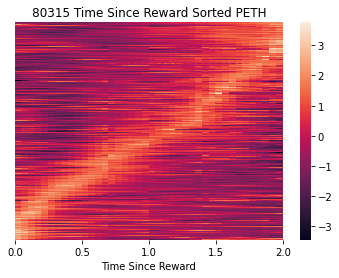

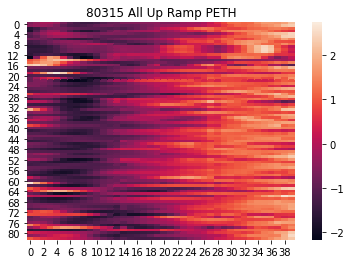

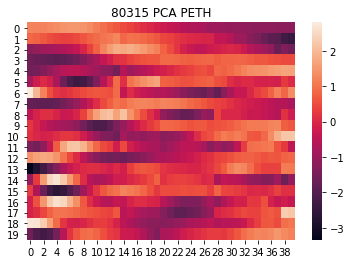

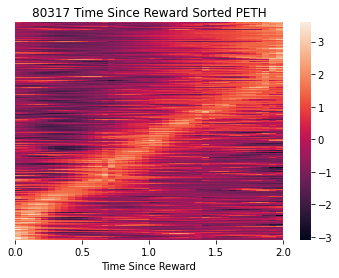

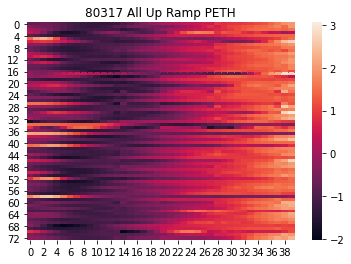

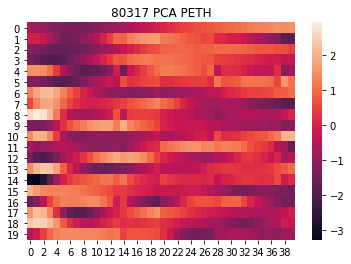

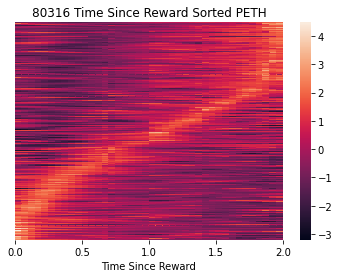

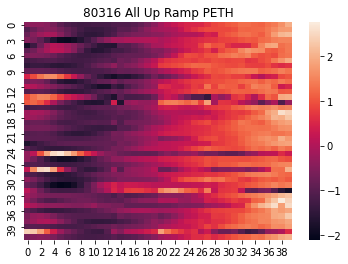

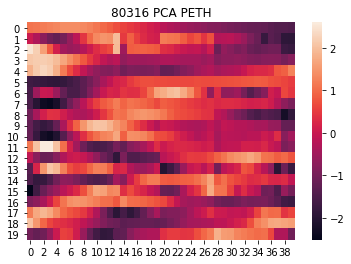

In [303]:
# do peak sorting for all  
decVar_bins = np.linspace(0,2,41)
classification_struct = peaksort(classification_struct,"timesince",decVar_bins,visualize = True) 

## 2) Generate datasets for classification

In [250]:
# generate a classification_dataset object per day
prop_val = .1
k = 10 
t1 = 500 
t2 = 1500
dataset = classification_dataset(classification_struct['80317'],t1,t2,prop_val,k)  


## 3) Investigate classification fidelity across population

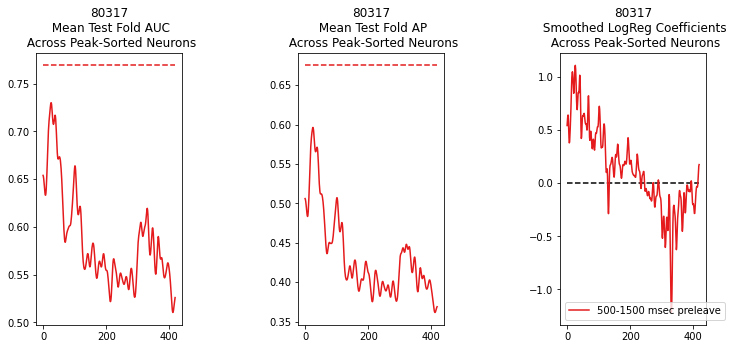

In [249]:
# first try logistic regression   
prop_val = .1
k = 5  
t1_range = [500] 
t2_range = [1500]
days = ['80317']
singleCellRegression(classification_struct,t1_range,t2_range,prop_val,k,days,gauss_smooth_sd = 3)


## 4) Ramping population analysis

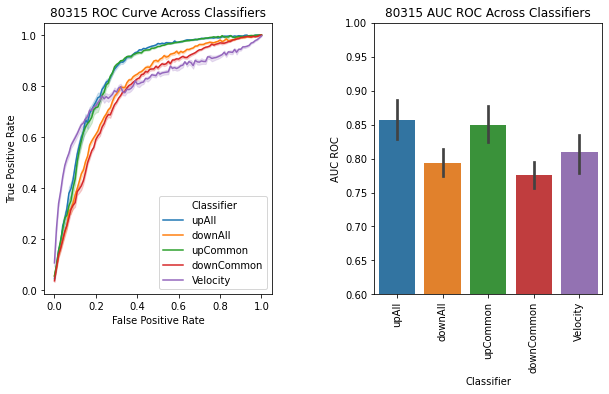

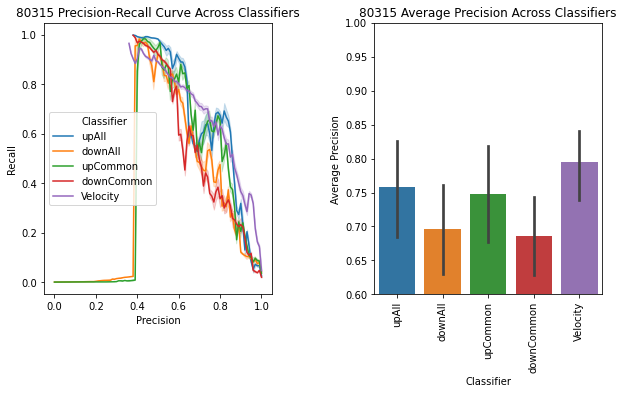

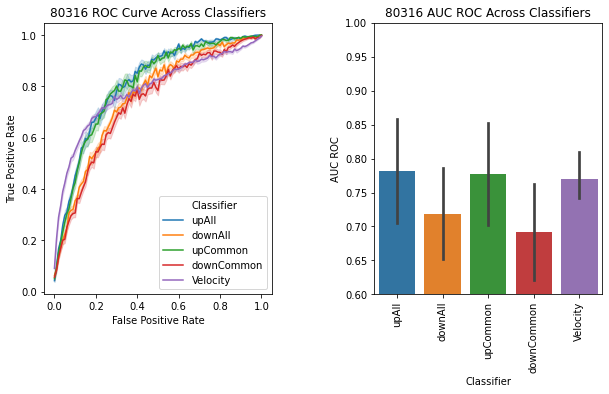

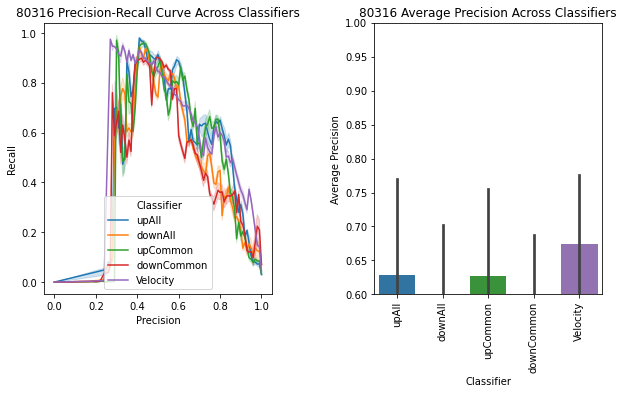

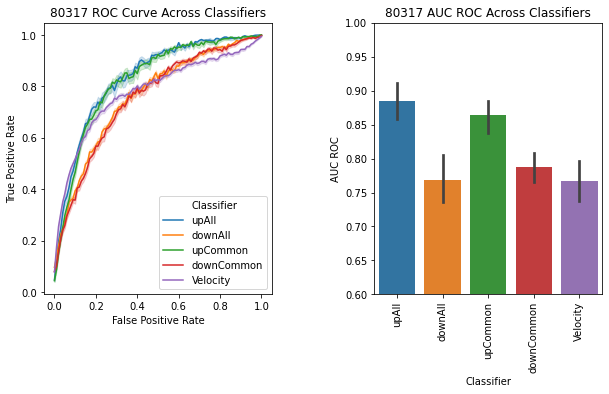

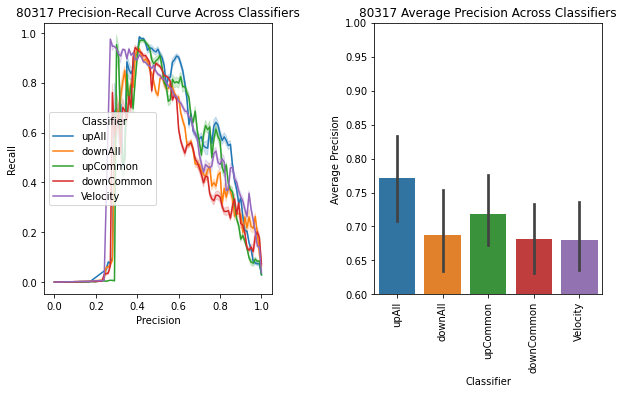

In [219]:
prop_val = .1
k = 5  
colors = plt.get_cmap('Set1',lut = 4)  
t1_range = [500] 
t2_range = [1500] 
ramp_pops = ['upAll','downAll','upCommon','downCommon'] 
roc_results = pd.DataFrame(columns = ["Classifier","threshold","fpr","tpr"],dtype = np.float64)
pr_results = pd.DataFrame(columns = ["Classifier","threshold","precision","recall"],dtype = np.float64) 

for day_key in ['80315','80316','80317']:  
    for i,(t1,t2) in enumerate(zip(t1_range,t2_range)):
        dataset = classification_dataset(classification_struct[day_key],t1,t2,prop_val,k)   
        model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0)) 
        auc = np.zeros((len(ramp_pops)+1,dataset.k))
        ap = np.zeros((len(ramp_pops)+1,dataset.k))
        coeffs = np.zeros(len(ramp_pops)) 
#         bar = IncrementalBar('Training single cell regressions', max = dataset.n_neurons, check_tty=False, hide_cursor=False)
        for rIx,ramp_pop in enumerate(ramp_pops):
            (X_train,y_train),(X_val,y_val) = dataset.gen_rampDataset(ramp_pop)    
            i_auc,i_ap,i_roc_results,i_pr_results = AUC_AP_evaluation(dataset,model,ramp_pop,X_train.T,y_train) 
            roc_results = roc_results.append(i_roc_results) 
            pr_results = pr_results.append(i_pr_results)
            auc[rIx,:] = i_auc
            ap[rIx,:] = i_ap
            coeffs[rIx] = model[1].coef_[0][0]

        (X_train_vel,y_train),(X_val_vel,y_val) = dataset.gen_velDataset()   
        auc_vel,ap_vel,vel_roc_results,vel_pr_results = AUC_AP_evaluation(dataset,model,"Velocity",X_train_vel,y_train)  
        roc_results = roc_results.append(vel_roc_results) 
        pr_results = pr_results.append(vel_pr_results) 
        auc[-1,:] = auc_vel
        ap[-1,:] = ap_vel
    
    visualize_roc_pr(roc_results,auc,pr_results,ap,day_key)


## PCA

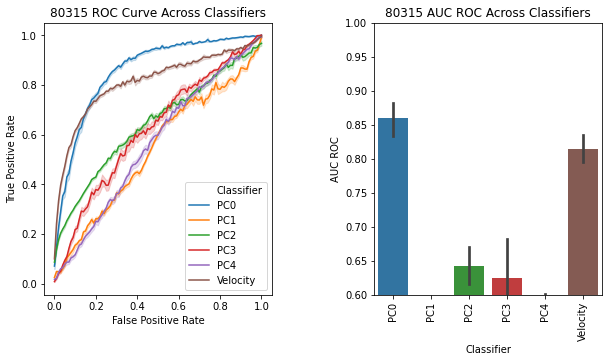

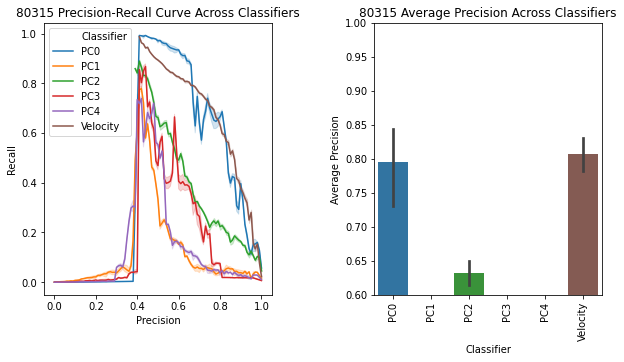

In [318]:
prop_val = .1
k = 5   
nPCs = 5
colors = plt.get_cmap('Set1',lut = 4)  
t1_range = [500] 
t2_range = [1500] 
roc_results = pd.DataFrame(columns = ["Classifier","threshold","fpr","tpr"],dtype = np.float64)
pr_results = pd.DataFrame(columns = ["Classifier","threshold","precision","recall"],dtype = np.float64) 

for day_key in ['80315']:  
    for i,(t1,t2) in enumerate(zip(t1_range,t2_range)):
        dataset = classification_dataset(classification_struct[day_key],t1,t2,prop_val,k)   
        model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0)) 
        auc = np.zeros((nPCs+1,dataset.k))
        ap = np.zeros((nPCs+1,dataset.k))
        coeffs = np.zeros(nPCs+1) 
        for pIdx in range(nPCs):
            (X_train,y_train),(X_val,y_val) = dataset.gen_pcaDataset(np.array([pIdx]))    
            i_auc,i_ap,i_roc_results,i_pr_results = AUC_AP_evaluation(dataset,model,"PC%i"%pIdx,X_train.T,y_train) 
            roc_results = roc_results.append(i_roc_results) 
            pr_results = pr_results.append(i_pr_results)
            auc[pIdx,:] = i_auc
            ap[pIdx,:] = i_ap
            coeffs[pIdx] = model[1].coef_[0][0]

        (X_train_vel,y_train),(X_val_vel,y_val) = dataset.gen_velDataset()   
        auc_vel,ap_vel,vel_roc_results,vel_pr_results = AUC_AP_evaluation(dataset,model,"Velocity",X_train_vel,y_train)  
        roc_results = roc_results.append(vel_roc_results) 
        pr_results = pr_results.append(vel_pr_results) 
        auc[-1,:] = auc_vel
        ap[-1,:] = ap_vel
    
    visualize_roc_pr(roc_results,auc,pr_results,ap,day_key)

## Forward search  
- Add neurons to regression one-by-one, starting with the least predictive

In [280]:
prop_val = .1
k = 5  
t1 = 1000 
t2 = 1500
for day_key in [list(classification_struct.keys())[0]]:
    dataset = classification_dataset(classification_struct[day_key],t1,t2,prop_val,k)   
    mean_auc = np.zeros(dataset.n_neurons) 
    mean_ap = np.zeros(dataset.n_neurons)  
    coeffs = np.zeros(dataset.n_neurons)
    for neuron in range(dataset.n_neurons): 
        model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0)) 
        (X_train,y_train),(X_val,y_val) = dataset.gen_cellDataset(np.array([neuron]))   
        auc,ap = AUC_AP_evaluation(dataset,model,X_train.T,y_train) 
        mean_auc[neuron] = np.mean(auc) 
        mean_ap[neuron] = np.mean(ap)  
        if neuron % 100 == 0: 
            print("Neuron %i complete"%neuron)  
    print("Session %s Complete"%day_key)

Neuron 0 complete
Neuron 100 complete
Neuron 200 complete
Neuron 300 complete
Neuron 400 complete
Session 80317 Complete


Performing forward search |████████████████████████████████| 75/75


Text(0.5, 1.0, '80317\n Mean Test Fold AP\n Along Forward Search')

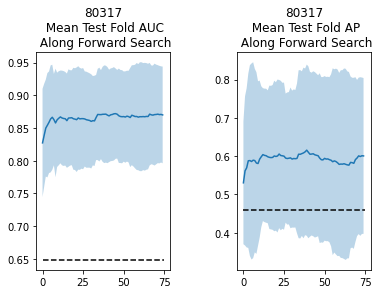

In [287]:
# Now add neurons in reverse AP order and see how fidelity increases ala Morcos 2016
reverse_ap_order = np.flip(np.argsort(mean_ap)) 
fwd_search_neurons = 75
mean_auc_fwd = np.zeros(fwd_search_neurons)  
sem_auc_fwd = np.zeros(fwd_search_neurons) 
mean_ap_fwd = np.zeros(fwd_search_neurons) 
sem_ap_fwd = np.zeros(fwd_search_neurons)
bar = IncrementalBar('Performing forward search', max = fwd_search_neurons, check_tty=False, hide_cursor=False) 

for added_neuron in range(fwd_search_neurons): 
    model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0)) 
    (X_train,y_train),(X_val,y_val) = dataset.gen_cellDataset(reverse_ap_order[:added_neuron+1])   
    
    auc,ap = AUC_AP_evaluation(dataset,model,X_train.T,y_train) 
    mean_auc_fwd[added_neuron] = np.mean(auc) 
    sem_auc_fwd[added_neuron] = 1.96 * np.std(auc)
    mean_ap_fwd[added_neuron] = np.mean(ap)   
    sem_ap_fwd[added_neuron] = 1.96 * np.std(ap)
#     if added_neuron % 10 == 0: 
#         print("Neuron %i AP: %.2f"%(added_neuron,np.mean(ap)))
    bar.next() 
bar.finish() 

# visualize forward search results 
plt.figure() 
plt.subplots_adjust(wspace = .5) 
plt.subplot(1,2,1)
#     plt.plot(gaussian_filter(mean_auc,2))   
plt.plot(mean_auc_fwd) 
plt.fill_between(range(fwd_search_neurons), mean_auc_fwd-sem_auc_fwd, mean_auc_fwd+sem_auc_fwd,alpha = .3)
plt.hlines(np.mean(auc_vel),0,fwd_search_neurons,linestyle = 'dashed')
plt.title("%s\n Mean Test Fold AUC\n Along Forward Search"%day_key)
plt.subplot(1,2,2)
#     plt.plot(gaussian_filter(mean_ap,2))  
plt.plot(mean_ap_fwd) 
plt.fill_between(range(fwd_search_neurons), mean_ap_fwd-sem_ap_fwd, mean_ap_fwd+sem_ap_fwd,alpha = .3)
plt.hlines(np.mean(ap_vel),0,fwd_search_neurons,linestyle = 'dashed')
plt.title("%s\n Mean Test Fold AP\n Along Forward Search"%day_key) 

## Can we get support vector classifiers to run if we don't predict probabilities? 

In [231]:
prop_val = .1
k = 5  
np.seterr(divide='ignore', invalid='ignore')
for day_key in [list(classification_struct.keys())[1]]:
    dataset = classification_dataset(classification_struct[day_key],1000,1500,prop_val,k)   
    mean_tpr = np.zeros(dataset.n_neurons) 
    mean_fpr = np.zeros(dataset.n_neurons)  
    mean_precision = np.zeros(dataset.n_neurons) 
    bar = IncrementalBar('Performing RBF SVC Over neurons', max = dataset.n_neurons, check_tty=False, hide_cursor=False)
    for neuron in range(dataset.n_neurons): 
        model = make_pipeline(StandardScaler(), SVC(kernel = 'rbf',gamma='auto')) 
        (X_train,y_train),(X_val,y_val) = dataset.gen_cellDataset(np.array([neuron]))   
        confusion_mat = confusionMat_evaluation(dataset,model,X_train.T,y_train)  
        tpr_folds = confusion_mat[:,1,1] / (confusion_mat[:,1,1] + confusion_mat[:,1,0]) 
        fpr_folds = confusion_mat[:,0,1]  / (confusion_mat[:,0,1] + confusion_mat[:,0,0])
        precision_folds = confusion_mat[:,1,1]  / (confusion_mat[:,1,1] + confusion_mat[:,0,1])
        mean_tpr[neuron] = np.mean(tpr_folds) 
        mean_fpr[neuron] = np.mean(fpr_folds)   
        mean_precision[neuron] = np.mean(precision_folds) 
        
        bar.next() 
    bar.finish()


Performing RBF SVC Over neurons |████████████████████████████████| 504/504


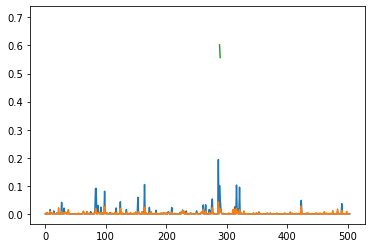

In [233]:
plt.plot(mean_tpr) 
plt.plot(mean_fpr)
plt.plot(mean_precision)

In [30]:
# just figuring out PCA
pca = PCA(n_components = 2) 
data = zscore(np.array([[1,2,3],[2,3,1],[1,2,3]]))
pca.fit(data)  

print(data)
print(np.matmul(pca.components_,data)) 

[[ 0.81649658  0.81649658 -0.81649658]
 [ 1.44337567  1.44337567 -1.44337567]]
[[-0.70710678 -0.70710678  0.70710678]
 [ 1.41421356  1.41421356 -1.41421356]
 [-0.70710678 -0.70710678  0.70710678]]


## Old code

In [ ]:
# now try adding polynomial features - is this going to improve among mid responsive? 
# not particularly
poly = PolynomialFeatures(2)

prop_val = .1
k = 10 
for day_key in [list(classification_struct.keys())[1]]:
    dataset = classification_dataset(classification_struct[day_key],prop_val,k)   
    mean_auc = np.zeros(dataset.n_neurons) 
    mean_ap = np.zeros(dataset.n_neurons)  
    coeffs = np.zeros(dataset.n_neurons)
    for neuron in range(dataset.n_neurons): 
        model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0)) 
        (X_train,y_train),(X_val,y_val) = dataset.gen_cellDataset(np.array([neuron]))   
        auc,ap = AUC_AP_evaluation(dataset,model,poly.fit_transform(X_train.T),y_train)  
        mean_auc[neuron] = np.mean(auc) 
        mean_ap[neuron] = np.mean(ap)  
        coeffs[neuron] = model[1].coef_[0][2]
        if neuron % 100 == 0: 
            print("Neuron %i complete"%neuron)  
        

    (X_train_vel,y_train),(X_val_vel,y_val) = dataset.gen_velDataset()   
    auc_vel,ap_vel,_,_ = AUC_AP_evaluation(dataset,model,"polyFeatures",poly.fit_transform(X_train_vel),y_train)  

    # Now visualize results across neurons   
    plt.figure() 
    plt.subplots_adjust(wspace = .5) 
    plt.subplot(1,2,1)
#     plt.plot(gaussian_filter(mean_auc,2))   
    plt.plot(mean_auc) 
    plt.hlines(np.mean(auc_vel),0,dataset.n_neurons,linestyle = 'dashed')
    plt.title("%s\n Mean Test Fold AUC\n Across Peak-Sorted Neurons"%day_key)
    plt.subplot(1,2,2)
#     plt.plot(gaussian_filter(mean_ap,2))  
    plt.plot(mean_ap) 
    plt.hlines(np.mean(ap_vel),0,dataset.n_neurons,linestyle = 'dashed')
    plt.title("%s\n Mean Test Fold AP\n Across Peak-Sorted Neurons"%day_key) 
    
    plt.figure() 
    plt.plot(gaussian_filter(coeffs,2))
    plt.plot(coeffs) 
    plt.hlines(0,0,dataset.n_neurons,linestyle = 'dashed')
    plt.title("%s\n LogReg Quadratic Coefficients\n Across Peak-Sorted Neurons"%day_key)